In [1]:
import sys
sys.path.append('../py-code/')
import os
import gzip as gz
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from difflib import get_close_matches
from statsmodels.distributions.empirical_distribution import *
import scipy
from scipy.stats import norm
import scipy.stats as ss
import disrupt as dr
import amutils as at

In [2]:
def init_matplotlib():
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('tableau-colorblind10')
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [3]:
init_matplotlib()
plt.ion()

In [4]:
allmusic = dict({'pagerank':dict(), 'disruption':dict(), 'in_degree':dict()})
whosampled = dict({'pagerank':dict(), 'disruption':dict(), 'in_degree':dict()})

In [5]:
allmusic['disruption']['df'] = pd.read_csv('../centrality-csvs/allmusic_disruption.csv')
allmusic['pagerank']['df'] = pd.read_csv('../centrality-csvs/allmusic_pageranks.csv')
allmusic['in_degree']['df'] = pd.read_csv('../centrality-csvs/allmusic_in_degree.csv')

whosampled['disruption']['df'] = pd.read_csv('../centrality-csvs/whosampled_disruption_per_year.csv')
whosampled['pagerank']['df'] = pd.read_csv('../centrality-csvs/whosampled_pageranks_per_year.csv')
whosampled['in_degree']['df'] = pd.read_csv('../centrality-csvs/whosampled_in_degree_per_year.csv')

In [6]:
for data in [allmusic, whosampled]:
    for key in list(data.keys()):
        data[key]['df'].index = list(data[key]['df']['Unnamed: 0'])
        data[key]['df'] = data[key]['df'].drop(columns= ['Unnamed: 0'])

In [7]:
def to_rank(serie):
    serie = serie.sort_values().dropna()
    for i, artist in zip(range(len(serie)), serie.index):
        serie[artist] = i
    return serie

In [8]:
def to_rank_dataframe(data):
    ranked = list()
    for column in data.columns:
        ranked.append(to_rank(data[column]))
    return pd.DataFrame(ranked).T

In [9]:
def z_normalize(data, take_out_min = False, log = False):
    transformed = list()
    for ano in data.columns:
        pagerank = data[ano].dropna()
        if take_out_min:
            menor = pagerank.min()
            pagerank = pagerank[pagerank!=menor]
        if log:
            pagerank = np.log(pagerank)
        pagerank_zscore = (pagerank - pagerank.mean())/pagerank.std()
        transformed.append(pagerank_zscore)
    return pd.DataFrame(transformed).T

<br><h2>Top 5 evolution</h2><br>
<h4>Who sampled</h4><br>

In [10]:
top_5_index = list(set(whosampled['pagerank']['df']['2020'].sort_values(ascending=False)[:6].index) - {'Traditional Folk'})                   

<br><h4>Pagerank</h4><br>

In [11]:
pagerank_znormalized = z_normalize(whosampled['pagerank']['df'], take_out_min = True)

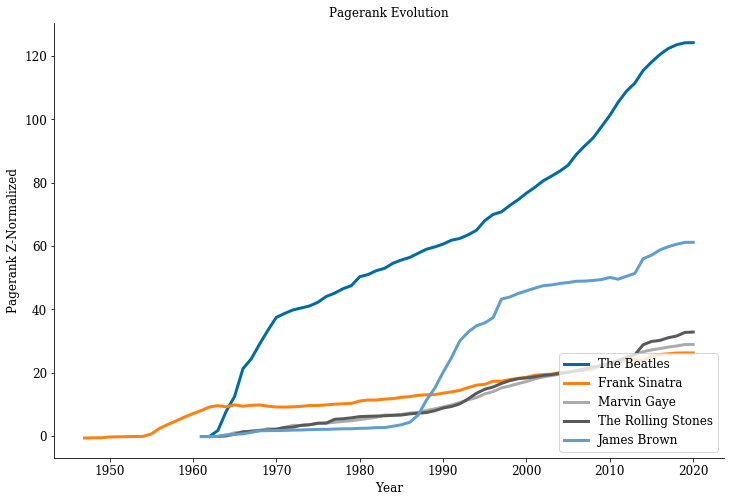

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
for artist in top_5_index:
    pagerank_znormalized.loc[artist].plot()
ax.legend(top_5_index, loc='lower right')
plt.xlabel('Year')
plt.ylabel('Pagerank Z-Normalized')
plt.title('Pagerank Evolution')
despine()

<br><h4>In-degree</h4><br>


In [13]:
in_degree_znormalized = z_normalize(whosampled['in_degree']['df'])

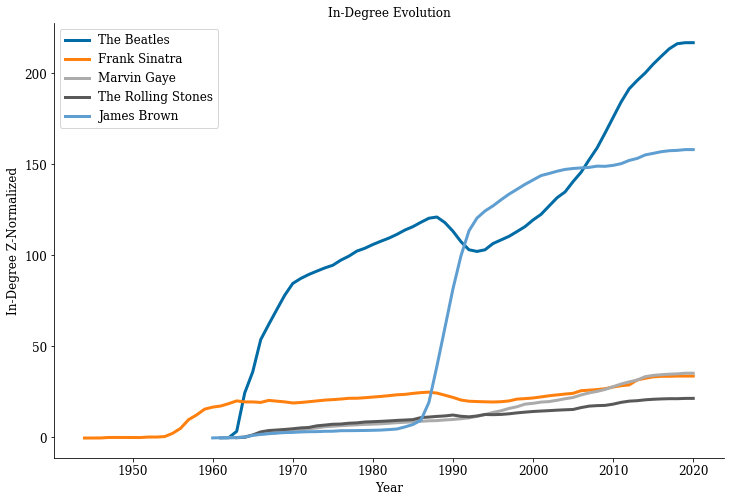

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
for artist in top_5_index:
    in_degree_znormalized.loc[artist].plot()
ax.legend(top_5_index, loc='upper left')
plt.xlabel('Year')
plt.ylabel('In-Degree Z-Normalized')
plt.title('In-Degree Evolution')
despine()

<br><h4>Disruption</h4><br>


In [15]:
disruption_znormalized = z_normalize(whosampled['disruption']['df'])

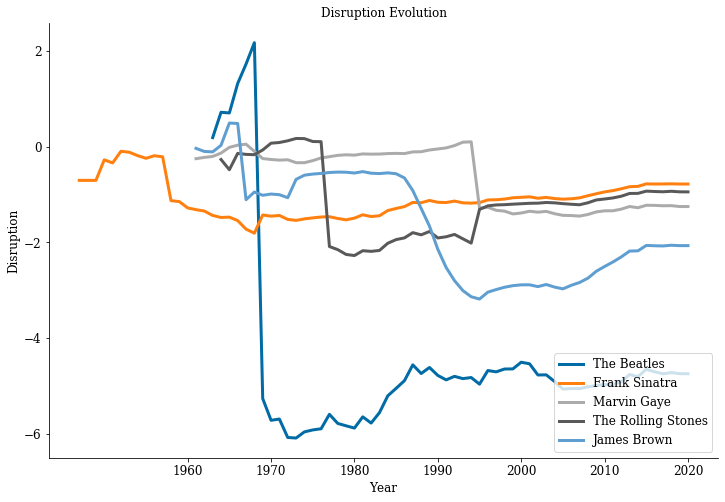

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
for artist in top_5_index:
    disruption_znormalized.loc[artist].plot()
ax.legend(top_5_index, loc='lower right')
plt.xlabel('Year')
plt.ylabel('Disruption')
plt.title('Disruption Evolution')
despine()

<br><h4>Allmusic</h4><br>

In [19]:
def load_am_json_data():
    fpath = '../data/allmusic-data.json.gz'
    with gz.open(fpath) as gzip_file:
        json_data = json.load(gzip_file)
        return json_data

In [20]:
allmusic_json = load_am_json_data()
names = {}
for key, val in allmusic_json.items():
    names[key] = val['name']

In [21]:
top_5_index = allmusic['pagerank']['df']['2010'].sort_values(ascending=False)[:5].index

<br><h4>Pagerank</h4><br>

In [34]:
pagerank_znormalized = z_normalize(allmusic['pagerank']['df'], take_out_min = True)

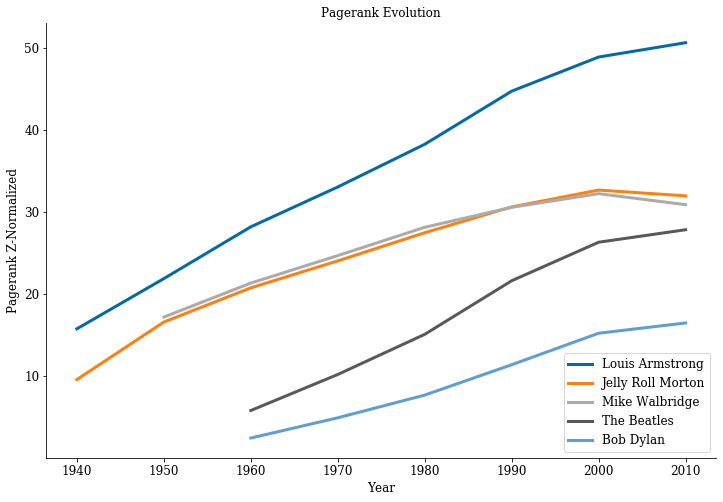

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
for artist in top_5_index:
    pagerank_znormalized.loc[artist].plot()
ax.legend([names[artist] for artist in top_5_index], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Pagerank Z-Normalized')
plt.title('Pagerank Evolution')
despine()

<br><h4>In-degree</h4><br>

In [24]:
in_degree_znormalized = z_normalize(allmusic['in_degree']['df'])

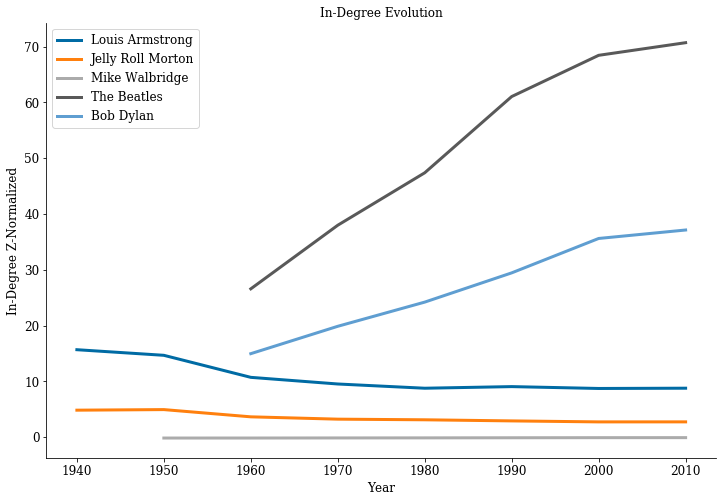

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
for artist in top_5_index:
    in_degree_znormalized.loc[artist].plot()
ax.legend([names[artist] for artist in top_5_index], loc='upper left')
plt.xlabel('Year')
plt.ylabel('In-Degree Z-Normalized')
plt.title('In-Degree Evolution')
despine()

<br><h4>Disruption</h4><br>

In [26]:
disruption_znormalized = z_normalize(allmusic['disruption']['df'])

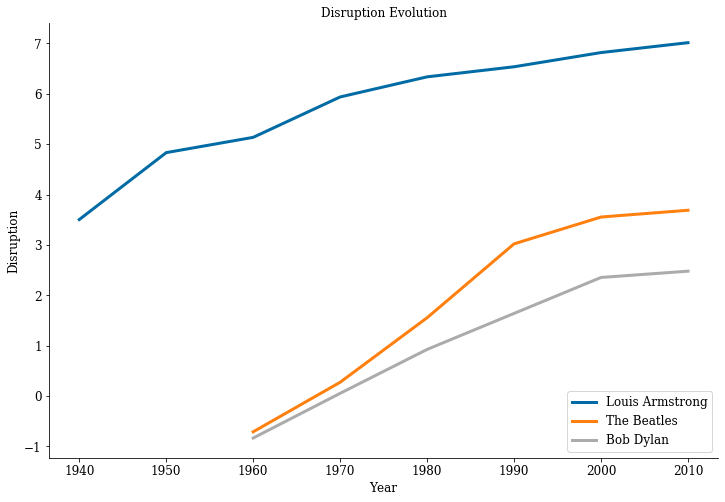

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
names_ploted = list()
for artist in top_5_index:
    try:
        disruption_znormalized.loc[artist].plot()
        names_ploted.append(names[artist])
    except:
        pass
ax.legend(names_ploted, loc='lower right')
plt.xlabel('Year')
plt.ylabel('Disruption')
plt.title('Disruption Evolution')
despine()